In [2]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Load the Data Files


In [158]:
df = (
    pl.read_parquet("june_processed.parquet")
    .sort(pl.col("Q"))
    .sort(pl.col("pol"), descending=True)
)
df = df.filter(pl.col("sample").str.starts_with("mono"))

display(df.head())
data = {}
for en, g in df.group_by("Beamline Energy [eV]", maintain_order=True):
    Q = g["Q"].to_numpy()
    R = g["r"].to_numpy()
    #  Grab the minimum value for the dark current
    dark_current_min = R.min()
    # Calculate initial dR
    dR = 0.1 * R + dark_current_min * Q
    # Ensure dR doesn't exceed 90% of R to keep R-dR positive
    dR = np.minimum(dR, 0.9 * R)
    ds = fit.XrayReflectDataset(data=(Q, R, dR))
    data[str(en[0])] = ds
energy_batches = [
    np.array([250, 275, 283.7, 284.2]),  # Structure
    df["Beamline Energy [eV]"].unique().to_numpy(),  # fixed structure
]
ooc = pd.read_csv("optical_constants.csv")

display(energy_batches[1])

Beamline Energy [eV],sample,pol,bt,Q,r
f64,str,str,str,f64,f64
283.7,"""monolayer""","""s""","""june""",0.0,1.0
275.0,"""monolayer""","""s""","""june""",0.001012,0.932947
280.0,"""monolayer""","""s""","""june""",0.00103,0.860302
281.0,"""monolayer""","""s""","""june""",0.001034,0.71063
281.2,"""monolayer""","""s""","""june""",0.001035,0.81888


array([250. , 275. , 280. , 281. , 281.2, 281.4, 281.6, 281.8, 282. ,
       282.3, 282.5, 282.7, 282.9, 283.1, 283.3, 283.5, 283.7, 284.2,
       285.1, 287. , 289. ])

# Load Optical Constants for Constraints and OOC instantiation


In [159]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab, tensor):
    """Set parameters from tensor."""
    rbounds = (
        tensor.real.min() * 0.9,
        tensor.real.max() * 1.1,
    )
    ibounds = (
        1e-8,
        tensor.imag.max() * 1.1,
    )
    slab.sld.xx.setp(vary=True, bounds=rbounds)
    slab.sld.zz.setp(vary=True, bounds=rbounds)
    slab.sld.ixx.setp(vary=True, bounds=ibounds)
    slab.sld.izz.setp(vary=True, bounds=ibounds)
    return slab


def force_isotropic_beta(slab):
    """Force beta to be isotropic."""
    slab.sld.beta.setp(vary=True, bounds=slab.sld.ixx.bounds)
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta)


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=True, bounds=(2, 3))
    return slab


def sio2(energy, thick=10.1, rough=4, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=True, bounds=(1, 2.3))
    return slab


def stratified_media(
    energy,
    total_thick=200,
    n_layers=3,
    thick_ratios=[5, 190, 8],
    density_values=[1.0, 1.0, 1.0],
    orientations=["_", "|", "\\"],
):
    """Constructs a layered material with a specified number of layers and thickness ratios."""
    slabs = None
    for i in range(n_layers):
        match orientations[i % len(orientations)]:
            case "_":
                rotation = 0
            case "|":
                rotation = np.pi / 2
            case "\\":
                rotation = np.pi / 4
        name = f"ZnPc - Layer {i + 1}"
        # Determine the thickness from the thickness ratios
        layer_thick = (
            total_thick * thick_ratios[i % len(thick_ratios)] / sum(thick_ratios)
        )
        roughness = 0.1  # * layer_thick
        slab = fit.UniTensorSLD(
            ooc, density=density_values[i], rotation=rotation, energy=energy, name=name
        )(layer_thick, roughness)
        slab.thick.setp(vary=True, bounds=(layer_thick * 0, layer_thick * 5))
        slab.rough.setp(vary=True, bounds=(0, layer_thick // 2))
        slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
        slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 2))
        if slabs is None:
            slabs = slab
        else:
            slabs |= slab
    return slabs


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.81, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(np.pi / 4, 7 * np.pi / 8))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.8, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 4))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | stratified_media(
            offset_energy,
            total_thick=200,
            n_layers=3,
            thick_ratios=[10, 180, 10],
        )
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab


stacks = {str(round(e, 1)): construct_slab(e) for e in energy_batches[1]}
stacks.keys()

dict_keys(['250.0', '275.0', '280.0', '281.0', '281.2', '281.4', '281.6', '281.8', '282.0', '282.3', '282.5', '282.7', '282.9', '283.1', '283.3', '283.5', '283.7', '284.2', '285.1', '287.0', '289.0'])

# Fit Delta Crossing to consistent slab model


In [160]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [161]:
#  Constrain the thickness and roughness of each layers to match between energies
for e in energy_batches[1]:
    if e == 283.7:
        continue
    for i, slab in enumerate(stacks[str(round(e, 1))]):
        slab.thick.setp(vary=None, constraint=stacks["283.7"][i].thick)
        slab.rough.setp(vary=None, constraint=stacks["283.7"][i].rough)
        safely_setp(
            slab.sld, "density", vary=None, constraint=stacks["283.7"][i].sld.density
        )
        safely_setp(
            slab.sld, "rotation", vary=None, constraint=stacks["283.7"][i].sld.rotation
        )

In [162]:
models = {
    str(e): fit.ReflectModel.build_model(e, stacks[str(e)], data[str(e)])
    for e in energy_batches[1]
}
for e, model in models.items():
    if e not in ["250.0", "283.7"]:
        model.bkg = 0
    # Constrain the energy offset to be the same for all models
    if model.name.endswith("283.7"):
        model.energy_offset.setp(vary=True, bounds=(-0.5, 0.5))
    else:
        model.energy_offset.setp(vary=None, constraint=models["283.7"].energy_offset)
objectives = [
    fit.AnisotropyObjective.build_objective(models[str(e)], data[str(e)])
    for e in energy_batches[1]
]

for objective in objectives:
    objective.transform = Transform("logY")

global_obj = fit.GlobalObjective(objectives)

/tmp/ipykernel_166090/1333636212.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


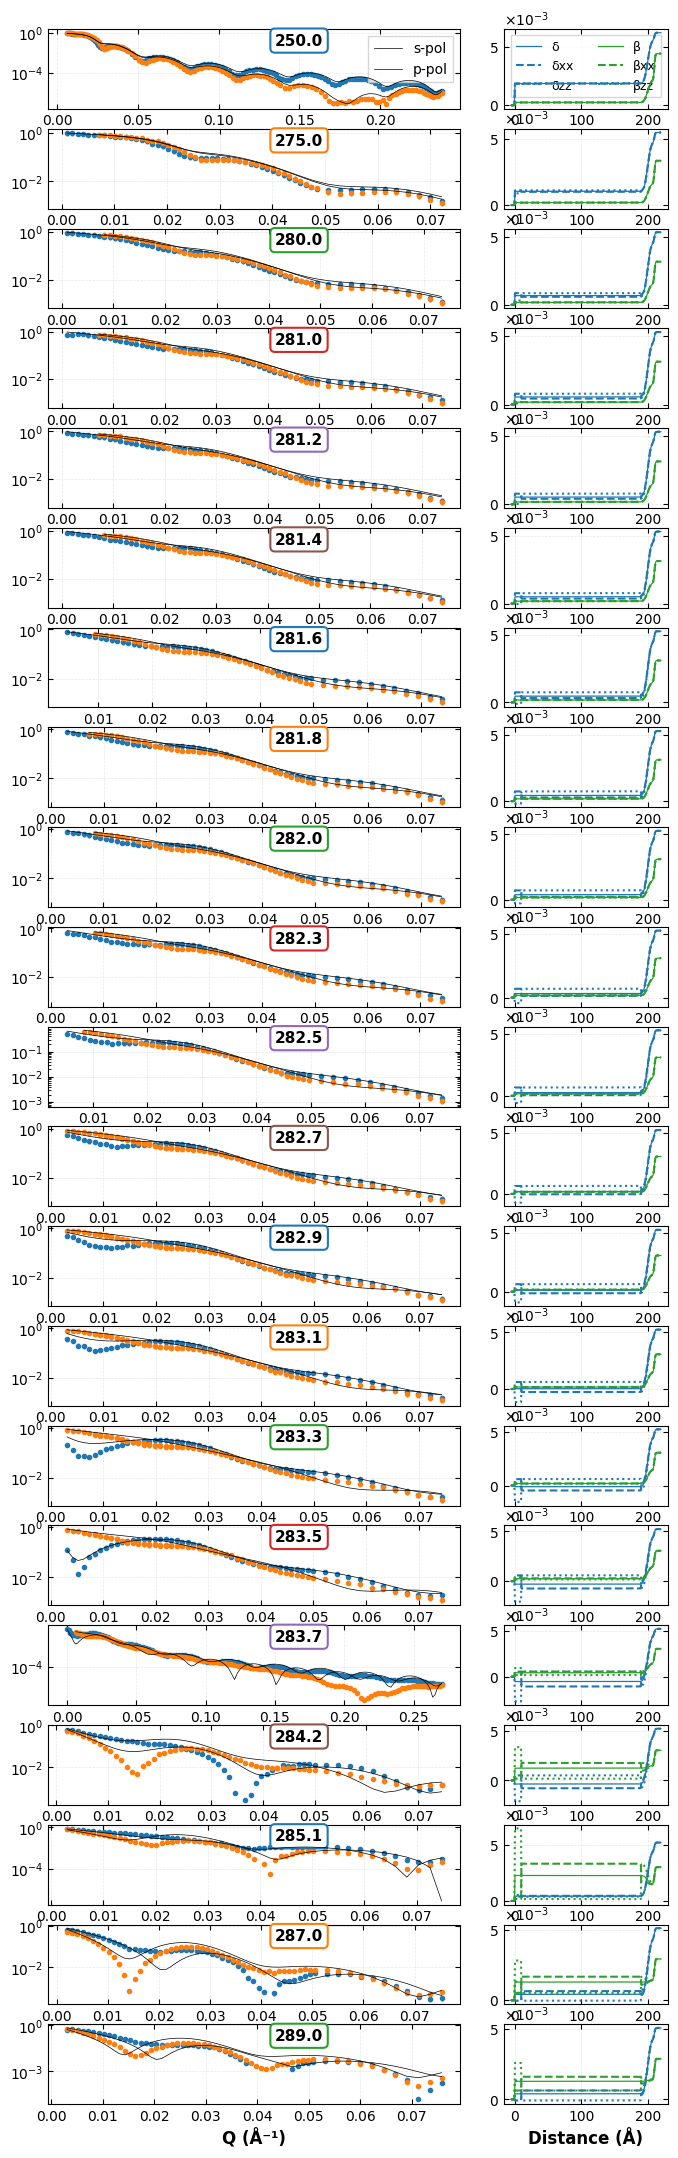

In [163]:
from typing import Any


from matplotlib.figure import Figure


def plot(  # type: ignore
    obj,
    samples=0,
    model=None,
    ax=None,
    ax_anisotropy=None,
    color_err=("C0", "C1", "C2"),
    color_fit=("C0", "C1", "C2"),
    data_kwargs=None,
    model_kwargs=None,
    show_s=True,
    show_p=True,
    show_anisotropy=True,
):
    """
    Plot function that includes anisotropy information.

    Parameters
    ----------
    samples : int, optional
        Number of sample curves to plot from MCMC chain
    model : array-like, optional
        Model data to plot
    ax : matplotlib.Axes, optional
        Axes for reflectivity plot
    ax_anisotropy : matplotlib.Axes, optional
        Axes for anisotropy plot
    data_kwargs : dict, optional
        Keyword arguments for data plotting
    model_kwargs : dict, optional
        Keyword arguments for model plotting
    show_s : bool, optional
        Whether to show s-polarization data
    show_p : bool, optional
        Whether to show p-polarization data
    show_anisotropy : bool, optional
        Whether to show anisotropy plot

    Returns
    -------
    tuple
        (ax, ax_anisotropy) - matplotlib axes objects
    """
    import matplotlib.pyplot as plt

    if data_kwargs is None:
        data_kwargs = {}
    if model_kwargs is None:
        model_kwargs = {}

    # Set up axes
    if ax is None:
        if show_anisotropy:
            fig, axs = plt.subplots(
                nrows=2,
                sharex=False,
                figsize=(8, 6),
                gridspec_kw={"height_ratios": [3, 1]},
            )
            ax = axs[0]
            ax_anisotropy = axs[1]
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax_anisotropy = None
    elif ax_anisotropy is None and show_anisotropy:
        # Get the figure from the provided axis
        fig = ax.figure
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)
        ax_anisotropy = fig.add_subplot(gs[1], sharex=ax)

    # Check if we have separate s and p polarization data
    has_separate_pol = hasattr(obj.data, "s") and hasattr(obj.data, "p")

    # Plot data
    if has_separate_pol:
        # Plot s-polarization if requested
        if show_s:
            ax.errorbar(
                obj.data.s.x,  # type: ignore
                obj.data.s.y,  # type: ignore
                obj.data.s.y_err,  # type: ignore
                label=f"{obj.data.name} s-pol" if obj.data.name else "s-pol",
                marker="o",
                color=color_err[0],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate s-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "s"
            s_model = obj.model(obj.data.s.x)  # type: ignore
            ax.plot(
                obj.data.s.x,  # type: ignore
                s_model,
                color=color_fit[0],
                label="s-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol

        # Plot p-polarization if requested
        if show_p:
            ax.errorbar(
                obj.data.p.x,  # type: ignore
                obj.data.p.y,  # type: ignore
                obj.data.p.y_err,  # type: ignore
                label=f"{obj.data.name} p-pol" if obj.data.name else "p-pol",
                marker="o",
                color=color_err[1],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate p-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "p"
            p_model = obj.model(obj.data.p.x)  # type: ignore
            ax.plot(
                obj.data.p.x,  # type: ignore
                p_model,
                color=color_fit[1],
                label="p-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol
    else:
        # Handle combined data case
        ax.errorbar(
            obj.data.x,
            obj.data.y,
            obj.data.y_err,
            label=obj.data.name,
            marker="o",
            color=color_err[0],
            ms=3,
            lw=0,
            elinewidth=1,
            capsize=1,
            ecolor="k",
            **data_kwargs,
        )

        # Plot combined model
        model = obj.generative()
        _, _, model_transformed = obj._data_transform(model=model)

        if samples > 0:
            # Get sample curves from MCMC chain
            models = []
            for curve in obj._generate_generative_mcmc(ngen=samples):
                _, _, model_t = obj._data_transform(model=curve)
                models.append(model_t)
            models = np.array(models)

            # Show 1-sigma and 2-sigma confidence intervals
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 16, axis=0),  # type: ignore
                np.percentile(models, 84, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.5,
            )
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 2.5, axis=0),  # type: ignore
                np.percentile(models, 97.5, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.2,
            )

        # Plot the fit
        ax.plot(
            obj.data.x,
            model_transformed,  # type: ignore
            color=color_fit[1],
            label="fit",
            zorder=20,
            **model_kwargs,
        )

    # Plot anisotropy if enabled
    if (
        ax_anisotropy is not None
        and show_anisotropy
        and hasattr(obj.data, "anisotropy")
    ):
        ax_anisotropy.set_ylabel("Anisotropy")

        # Plot anisotropy model
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.model.anisotropy(obj.data.anisotropy.x),  # type: ignore
            color=color_fit[2],
            zorder=20,
            label="model",
        )

        # Plot anisotropy data
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.data.anisotropy.y,  # type: ignore
            color=color_err[2],
            marker="o",
            markersize=3,
            linestyle="None",
            label="data",
        )

        ax_anisotropy.legend()
        ax_anisotropy.axhline(0, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])
        ax_anisotropy.set_xlabel(r"$q (\AA^{-1})$")

    # Finalize styling
    ax.set_ylabel("Reflectivity")
    ax.set_yscale("log")
    ax.legend()

    return ax, ax_anisotropy


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        plot(
            o,
            ax=ax[i][0],
            show_anisotropy=False,
            color_fit=("k", "k", "k"),
            model_kwargs={"lw": 0.5},
        )
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax


plot_reflectivity_and_structure(global_obj, figsize=(8, 25))
plt.show()

In [166]:
from typing import TypeVar

T = TypeVar("T")


def fitting(
    obj: T, recursion_limit=2, workers=-1, *, mcmc=False, **kwargs
) -> tuple[T, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : T
        The objective function to minimize (can be AnisotropyObjective or GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.
    **kwargs : dict
        Additional keyword arguments for the fitter.

    Returns
    -------
    tuple[T, fit.CurveFitter]
        The fitted objective and the fitter used.
    """
    import copy

    objective: fit.AnisotropyObjective = copy.deepcopy(obj)
    fitter: fit.CurveFitter = fit.CurveFitter(objective, **kwargs)
    fitter.initialise(random_state=43)
    fitter.sample(
        steps=100,
        random_state=42,
        skip_check=True,
    )
    fitter.reset()
    target = "nlpost"  # nlpost accounts for uncertainty in the data
    # Recursively use the differential evolution algorithm to locate the minima
    for i in range(recursion_limit):
        fitter.fit(
            "differential_evolution",
            target=target,
            workers=workers,
            polish=False,
            updating="deferred",
        )
        fit.fitters._fix_bounds(objective, by_bounds=True)
    fitter.fit("L-BFGS-B", target=target)
    if mcmc:
        fit.fitters._fix_bounds(objective, by_bounds=True)
        fitter.initialise("jitter", 43)
        fitter.sample(
            steps=1000,
            random_state=42,
            skip_check=True,
        )
    return objective, fitter


fit_obj, fitter = fitting(global_obj, mcmc=True, recursion_limit=3)
# fit_obj = global_obj

100%|██████████| 100/100 [19:50<00:00, 11.91s/it]
0it [00:00, ?it/s]

: 

/tmp/ipykernel_166090/1333636212.py:373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


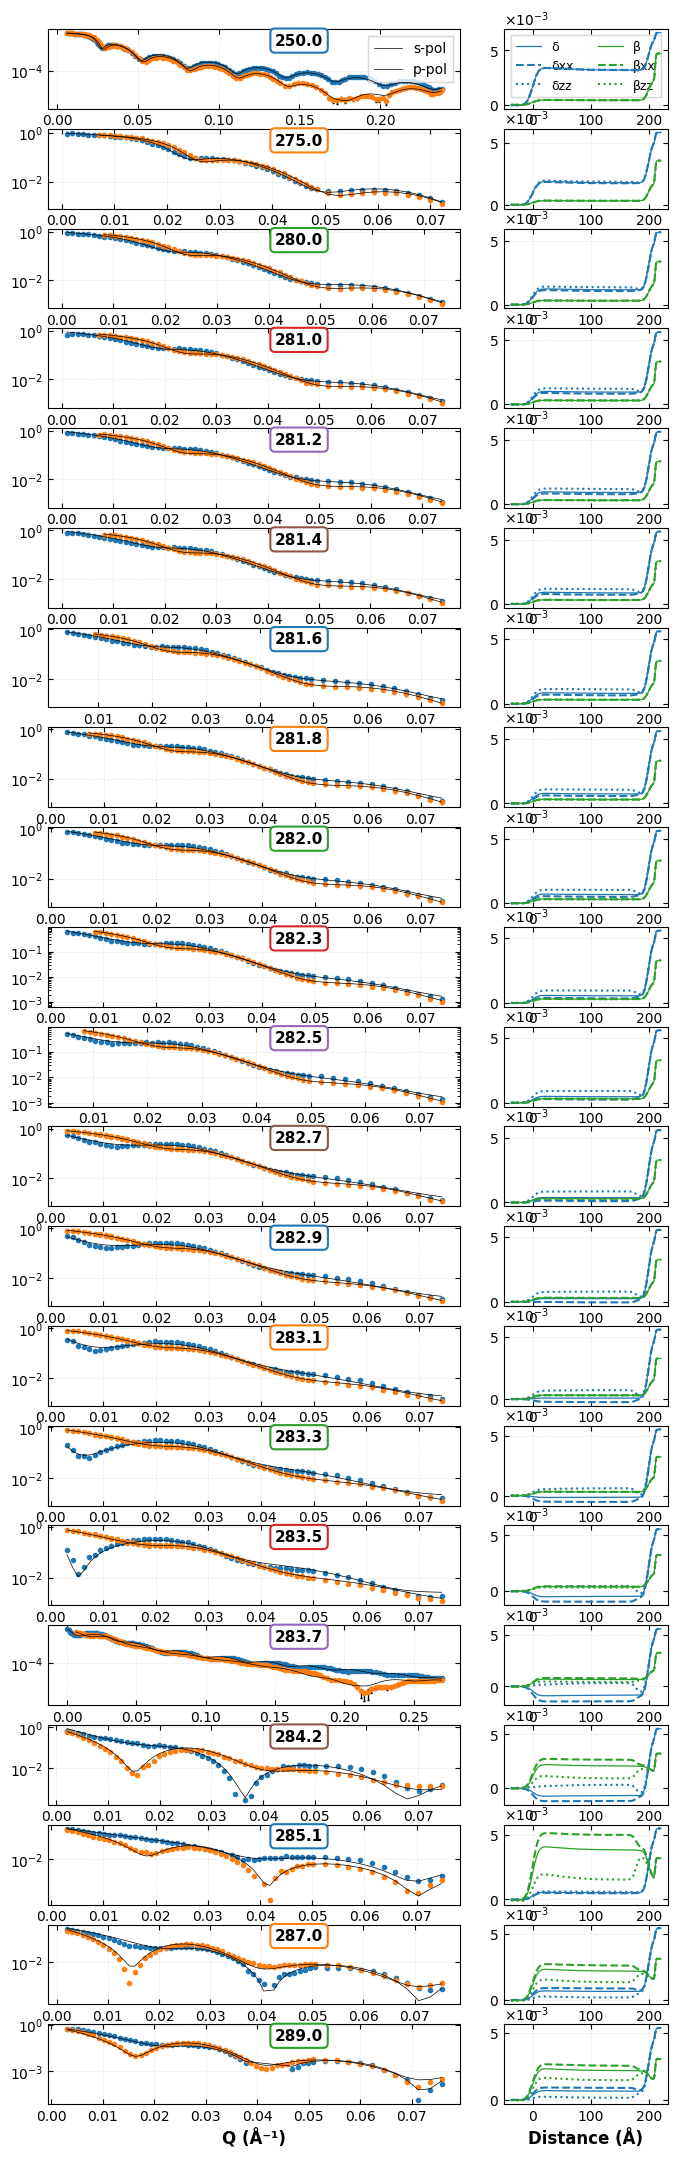

In [129]:
plot_reflectivity_and_structure(fit_obj, figsize=(8, 25))
plt.show()

In [120]:
print(fit_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:'energy_offset', value=0          , bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_s', value=0.001          , bounds=[-0.8, 0.8]>
<Parameter:'theta_offset_p', value=0.001          , bounds=[-0.8, 0.8]>
<Parameter:'ZnPc - Layer 1_thick', value=10          , bounds=[1.0, 20.0]>
<Parameter:'ZnPc - Layer 1_rough', value=0.1          , bounds=[0.0, 10.0]>
<Parameter:'ZnPc - Layer 1_density', value=1          , bounds=[1.2, 1.8]>
<Parameter:'ZnPc - Layer 1_rotation', value=1.2          , bounds=[0.0, 1.5707963267948966]>
<Parameter:'ZnPc - Layer 2_thick', value=180          , bounds=[18.0, 360.0]>
<Parameter:'ZnPc - Layer 2_rough', value=0.1          , bounds=[0.0, 180.0]>
<Parameter:'ZnPc - Layer 2_density', value=1          , bounds=[1.2, 1.8]>

In [121]:
from refnx.analysis import Parameters


def all_parameters(parameter_group):
    if isinstance(parameter_group, Parameters):
        params = []
        for param in parameter_group:
            params.extend(all_parameters(param))
        return params
    else:
        return [parameter_group]

In [148]:
def structure_params(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    params = []
    for objective in fit_objectives.objectives:
        for slab in objective.model.structure:
            if structure_property in ["density", "rotation"]:
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        params.append(param)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    params.append(param)
    return params


def print_structure_params(fit_objectives, structure_property):
    """Print the structure parameters from the fit objectives."""
    params = structure_params(fit_objectives, structure_property)
    print(f"Number of {structure_property} parameters: {len(params)}")
    print("-" * 82)
    for param in params:
        color = (
            "\033[94m" if param.vary else "\033[91m"
        )  # Light blue for vary=True, red for vary=False
        reset_color = "\033[0m"  # Reset to default color
        #  Round the param bounds to 3 decimal places
        bounds = (
            f"({param.bounds.lb:.3f}, {param.bounds.ub:.3f})"
            if param.bounds is not None
            else "(None, None)"
        )
        val = param.value
        err = param.stderr if param.stderr else 0
        print(
            f"{color}| {param.name:30} | {val:10.3f} ± {err:8.3f} | {str(bounds):18}{reset_color} |"
        )
    print("-" * 82)


print_structure_params(fit_obj, "thick")
print_structure_params(fit_obj, "rough")
print_structure_params(fit_obj, "density")
print_structure_params(fit_obj, "rotation")

Number of thick parameters: 4
----------------------------------------------------------------------------------
| ZnPc - Layer 1_thick           |     26.124 ±    3.497 | (0.000, 47.938)    |
| ZnPc - Layer 2_thick           |    150.614 ±    5.980 | (0.000, 308.500)   |
| ZnPc - Layer 3_thick           |     21.747 ±    2.520 | (0.000, 39.912)    |
| Oxide_283.7_thick              |     11.290 ±    1.296 | (0.000, 21.404)    |
----------------------------------------------------------------------------------
Number of rough parameters: 4
----------------------------------------------------------------------------------
| ZnPc - Layer 1_rough           |      7.968 ±    1.144 | (0.000, 15.460)    |
| ZnPc - Layer 2_rough           |     48.056 ±    7.276 | (0.000, 104.375)   |
| ZnPc - Layer 3_rough           |      4.794 ±    0.716 | (0.000, 10.075)    |
| Oxide_283.7_rough              |      5.715 ±    0.737 | (0.000, 11.088)    |
---------------------------------------------------

In [80]:
import pickle

with open("fitting_results_multilayer.pkl", "wb") as f:
    pickle.dump(fit_obj, f)

In [81]:
#  Get the orientation of each layer
orient = {}
densities = {}
for objective in fit_obj.objectives:
    for slab in objective.model.structure:
        slab_name = slab.name.split("_")[0]  # Get the slab name without the energy
        if hasattr(slab, "sld") and hasattr(slab.sld, "rotation"):
            if slab.sld.rotation.vary:
                orient[slab_name] = slab.sld.rotation.value
            if hasattr(slab.sld, "density") and slab.sld.density.vary:
                densities[slab_name] = slab.sld.density.value

energy_offset = fit_obj.objectives[0].model.energy_offset.value

#  For each slab, plot the optical constants
for slab_name, orientation in orient.items():
    plot_optical_constants_with_energies(
        ooc,
        energy_batches[1],
        en_shift=energy_offset,
        label=True,
        theta=orientation,
        density=densities.get(slab_name, 1.61),
        show_theta_range=False,
    )
    #  Set the x range and add a title
    plt.xlim(283, 289.5)
    plt.title(
        f"Optical Constants for {slab_name} at Orientation {np.degrees(orientation):.1f}°"
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #  Show the plot
plt.show()


NameError: name 'plot_optical_constants_with_energies' is not defined

In [149]:
#  Fix the thickness, and roughness of all layers to the 283.7 eV values
def fix_structure_parameters(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    import copy

    objective = copy.deepcopy(fit_objectives)
    for obj in objective.objectives:
        for slab in obj.model.structure:
            if structure_property == "density":
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        param.setp(vary=False)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    param.setp(vary=False)
    return objective


obj_fixed = fix_structure_parameters(fit_obj, "thick")
obj_fixed = fix_structure_parameters(obj_fixed, "rough")

#  Fix the density for the Si and SiO2 layers to the 283.7 eV values
for obj in obj_fixed.objectives:
    if obj.model.structure[-1].sld.density.vary:
        obj.model.structure[-1].sld.density.setp(vary=False, value=2.33)
    if obj.model.structure[-2].sld.density.vary:
        obj.model.structure[-2].sld.density.setp(vary=False)

print_structure_params(obj_fixed, "thick")
print_structure_params(obj_fixed, "rough")
print_structure_params(obj_fixed, "density")
print_structure_params(obj_fixed, "rotation")

Number of thick parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of rough parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of density parameters: 3
----------------------------------------------------------------------------------
| ZnPc - Layer 1_density         |      1.905 ±    0.204 | (1.610, 2.210)     |
| ZnPc - Layer 2_density         |      1.705 ±    0.174 | (1.400, 2.000)     |
| ZnPc - Layer 3_density         |      1.685 ±    0.193 | (1.380, 1.980)     |
----------------------------------------------------------------------------------
Number of rotation parameters: 3
----------------------------------------------------------------------------------
| ZnPc - Layer 1_rotation        |      1.150 ±    0.1

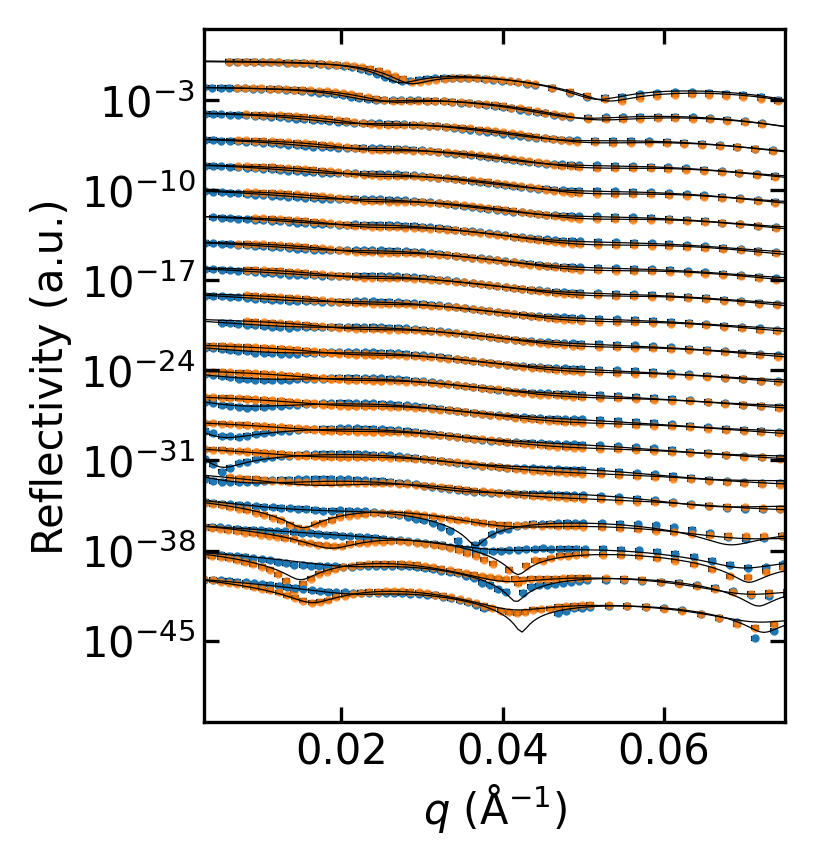

In [130]:
q = np.linspace(0.001, 0.25, 500)
fig, ax = plt.subplots(figsize=(2.5, 3), dpi=300)
used_energy = []

# Iterate over the objectives from the global fit object
for i, objective in enumerate(fit_obj.objectives):
    model = objective.model
    e = model.energy
    # print(model)
    d = objective.data

    # Calculate model reflectivity for s and p polarizations
    model_s = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)
    model_p = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)

    # Plot experimental data with an offset for clarity
    offset = 100**-i
    ax.errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="s-pol" if i == 1 else None,
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="p-pol" if i == 1 else None,
        zorder=-1,
        alpha=0.8,
    )

    # Plot the fit lines
    ax.plot(
        q,
        model_s * offset,
        color="k",
        lw=0.3,
        zorder=2,
        label="fit" if i == 1 else None,
    )
    ax.plot(q, model_p * offset, color="k", lw=0.3, zorder=2)

# Main plot formatting
ax.set_yscale("log")
ax.set_xlim(0.003, 0.075)
# ax.set_ylim(1e-8)
ax.set_xlabel(r"$q\ (\mathrm{\AA}^{-1})$", labelpad=2)
ax.set_ylabel("Reflectivity (a.u.)", labelpad=2)
ax.tick_params(axis="both", which="both", pad=2, width=0.8)

# Improve legend positioning and content
handles, labels = ax.get_legend_handles_labels()
if handles:  # Ensure legend is only created if there are labels
    order = [0, 2, 1]  # Reorder: s-pol, fit, p-pol
    # ax.legend(
    #     [handles[idx] for idx in order],
    #     [labels[idx] for idx in order],
    #     loc=(0.1, 0.0625),
    #     handletextpad=1,
    #     edgecolor="k",
    # )

plt.show()

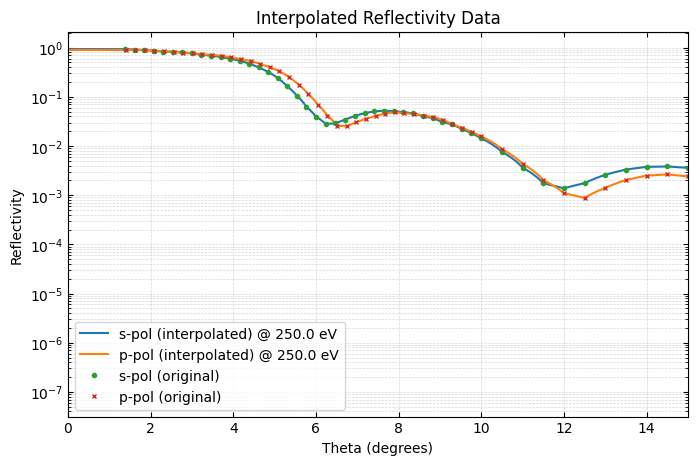

In [131]:
import numpy as np

import matplotlib.pyplot as plt

# Constants for q to theta conversion
hc = 12398.4198  # eV·Å


def q_to_theta(q, energy):
    """Convert q (in Å⁻¹) to theta (in degrees) for a given energy (in eV)."""
    # lambda (Å) = hc (eV·Å) / energy (eV)
    wavelength = hc / energy
    # q = (4 * pi / lambda) * sin(theta) => sin(theta) = q * lambda / (4 * pi)
    # np.arcsin can handle arrays
    theta_rad = np.arcsin(q * wavelength / (4 * np.pi))
    return np.degrees(theta_rad)


def theta_to_q(theta, energy):
    """Convert theta (in degrees) to q (in Å⁻¹) for a given energy (in eV)."""
    # lambda (Å) = hc (eV·Å) / energy (eV)
    wavelength = hc / energy
    # sin(theta) = q * lambda / (4 * pi) => q = (4 * pi / lambda) * sin(theta)
    theta_rad = np.radians(theta)
    return (4 * np.pi / wavelength) * np.sin(theta_rad)


# Find the global theta range across all datasets
min_theta = 0
max_theta = 60

for objective in fit_obj.objectives:
    energy = objective.model.energy
    # Combine s and p polarization q values
    q_values = np.concatenate((objective.data.s.x, objective.data.p.x))
    theta_values = q_to_theta(q_values, energy)
    current_min = np.min(theta_values)
    current_max = np.max(theta_values)
    if current_min < min_theta:
        min_theta = current_min
    # Use the tightest grouping
    if current_max < max_theta:
        max_theta = current_max

# Create a common theta grid
common_theta = np.linspace(min_theta, max_theta, 1000)

# Interpolate each dataset onto the common theta grid
interpolated_data = {}
for objective in fit_obj.objectives:
    energy = objective.model.energy

    # s-polarization
    theta_s = q_to_theta(objective.data.s.x, energy)
    # Sort by theta before interpolation
    sort_idx_s = np.argsort(theta_s)
    interp_s = np.interp(
        common_theta, theta_s[sort_idx_s], objective.data.s.y[sort_idx_s]
    )

    # p-polarization
    theta_p = q_to_theta(objective.data.p.x, energy)
    # Sort by theta before interpolation
    sort_idx_p = np.argsort(theta_p)
    interp_p = np.interp(
        common_theta, theta_p[sort_idx_p], objective.data.p.y[sort_idx_p]
    )

    interpolated_data[energy] = {"s": interp_s, "p": interp_p}

# Example: Plot the interpolated data for the first energy
first_energy = fit_obj.objectives[0].model.energy
plt.figure(figsize=(8, 5))
plt.plot(
    common_theta,
    interpolated_data[first_energy]["s"],
    label=f"s-pol (interpolated) @ {first_energy:.1f} eV",
)
plt.plot(
    common_theta,
    interpolated_data[first_energy]["p"],
    label=f"p-pol (interpolated) @ {first_energy:.1f} eV",
)

# For comparison, plot original data points
objective = fit_obj.objectives[0]
theta_s_orig = q_to_theta(objective.data.s.x, first_energy)
theta_p_orig = q_to_theta(objective.data.p.x, first_energy)
plt.plot(theta_s_orig, objective.data.s.y, "o", ms=3, label="s-pol (original)")
plt.plot(theta_p_orig, objective.data.p.y, "x", ms=3, label="p-pol (original)")

plt.yscale("log")
plt.xlabel("Theta (degrees)")
plt.ylabel("Reflectivity")
plt.xlim(common_theta[0], common_theta[-1])
plt.title("Interpolated Reflectivity Data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

/tmp/ipykernel_166090/4156309142.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


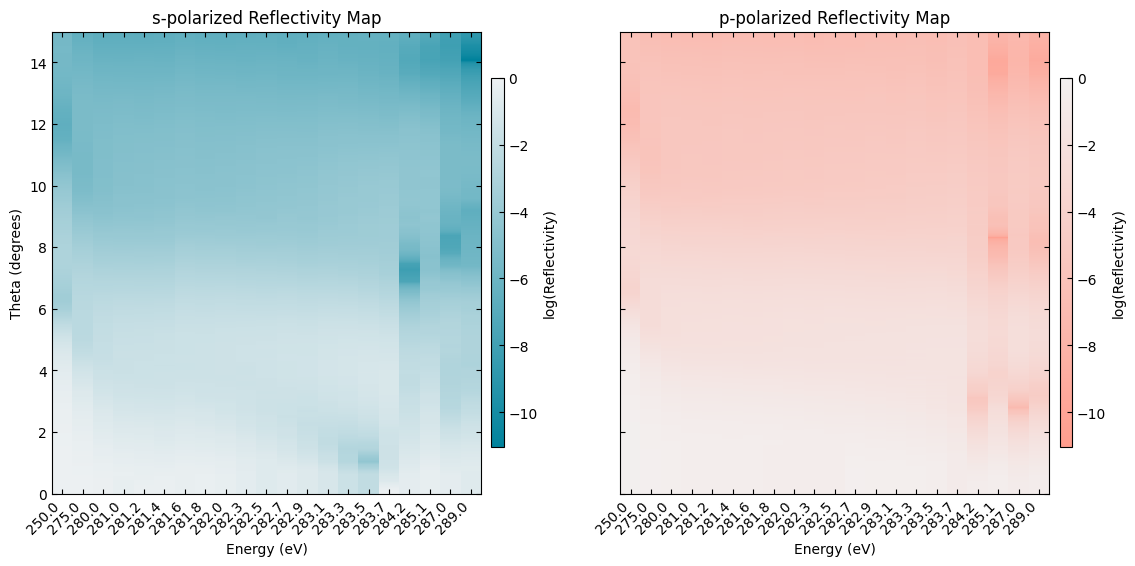

In [132]:
import seaborn as sns

# Get the sorted list of energies from the interpolated data
energies = sorted(interpolated_data.keys())

# Initialize lists to store the interpolated data for each energy
s_reflectivity_list = []
p_reflectivity_list = []
s_reflectivity_model = []
p_reflectivity_model = []

# Populate the lists with the interpolated reflectivity values
for i, energy in enumerate(energies):
    model = fit_obj.objectives[i].model
    model_s = fit.ReflectModel(
        model.structure,
        energy=energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(theta_to_q(common_theta, energy))
    model_p = fit.ReflectModel(
        model.structure,
        energy=energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(theta_to_q(common_theta, energy))
    s_reflectivity_model.append(model_s)
    p_reflectivity_model.append(model_p)
    s_reflectivity_list.append(interpolated_data[energy]["s"])
    p_reflectivity_list.append(interpolated_data[energy]["p"])

# Convert the lists into 2D NumPy arrays
# Axis 0 corresponds to energy, and axis 1 corresponds to the common theta values
s_reflectivity_map = np.array(s_reflectivity_list)
p_reflectivity_map = np.array(p_reflectivity_list)
# Convert the model reflectivity lists into 2D NumPy arrays
s_reflectivity_model = np.array(s_reflectivity_model)
p_reflectivity_model = np.array(p_reflectivity_model)

# Calculate the log of the reflectivity maps
log_s_map = np.log(s_reflectivity_map)
log_p_map = np.log(p_reflectivity_map)

# Determine the global min and max for the color scale
vmin = min(log_s_map.min(), log_p_map.min())
vmax = max(log_s_map.max(), log_p_map.max())


# Create a figure with two subplots to visualize the 2D arrays
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1}
)
cmap_s = sns.color_palette("light:#00829c_r", as_cmap=True)
cmap_p = sns.color_palette("light:#ff9d8d_r", as_cmap=True)

# Plot the s-polarized reflectivity map
im1 = ax1.imshow(
    log_s_map.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(energies), common_theta.min(), common_theta.max()],
    cmap=cmap_s,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax1.set_title("s-polarized Reflectivity Map")
ax1.set_ylabel("Theta (degrees)")
ax1.set_xlabel("Energy (eV)")
#  Rotate the ticks on the x-axis
ax1.set_xticks(np.arange(len(energies)) + 0.5)
ax1.set_xticklabels([f"{e:.1f}" for e in energies], rotation=45, ha="right")
fig.colorbar(
    im1,
    ax=ax1,
    label="log(Reflectivity)",
    location="right",
    pad=0.02,
    shrink=0.8,
    aspect=30,
)
# Plot the p-polarized reflectivity map
im2 = ax2.imshow(
    log_p_map.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(energies), common_theta.min(), common_theta.max()],
    cmap=cmap_p,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax2.set_title("p-polarized Reflectivity Map")
ax2.set_xlabel("Energy (eV)")
ax2.set_xticks(np.arange(len(energies)) + 0.5)
ax2.set_xticklabels([f"{e:.1f}" for e in energies], rotation=45, ha="right")
fig.colorbar(
    im2,
    ax=ax2,
    label="log(Reflectivity)",
    location="right",
    pad=0.02,
    shrink=0.8,
    aspect=30,
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_166090/187835606.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


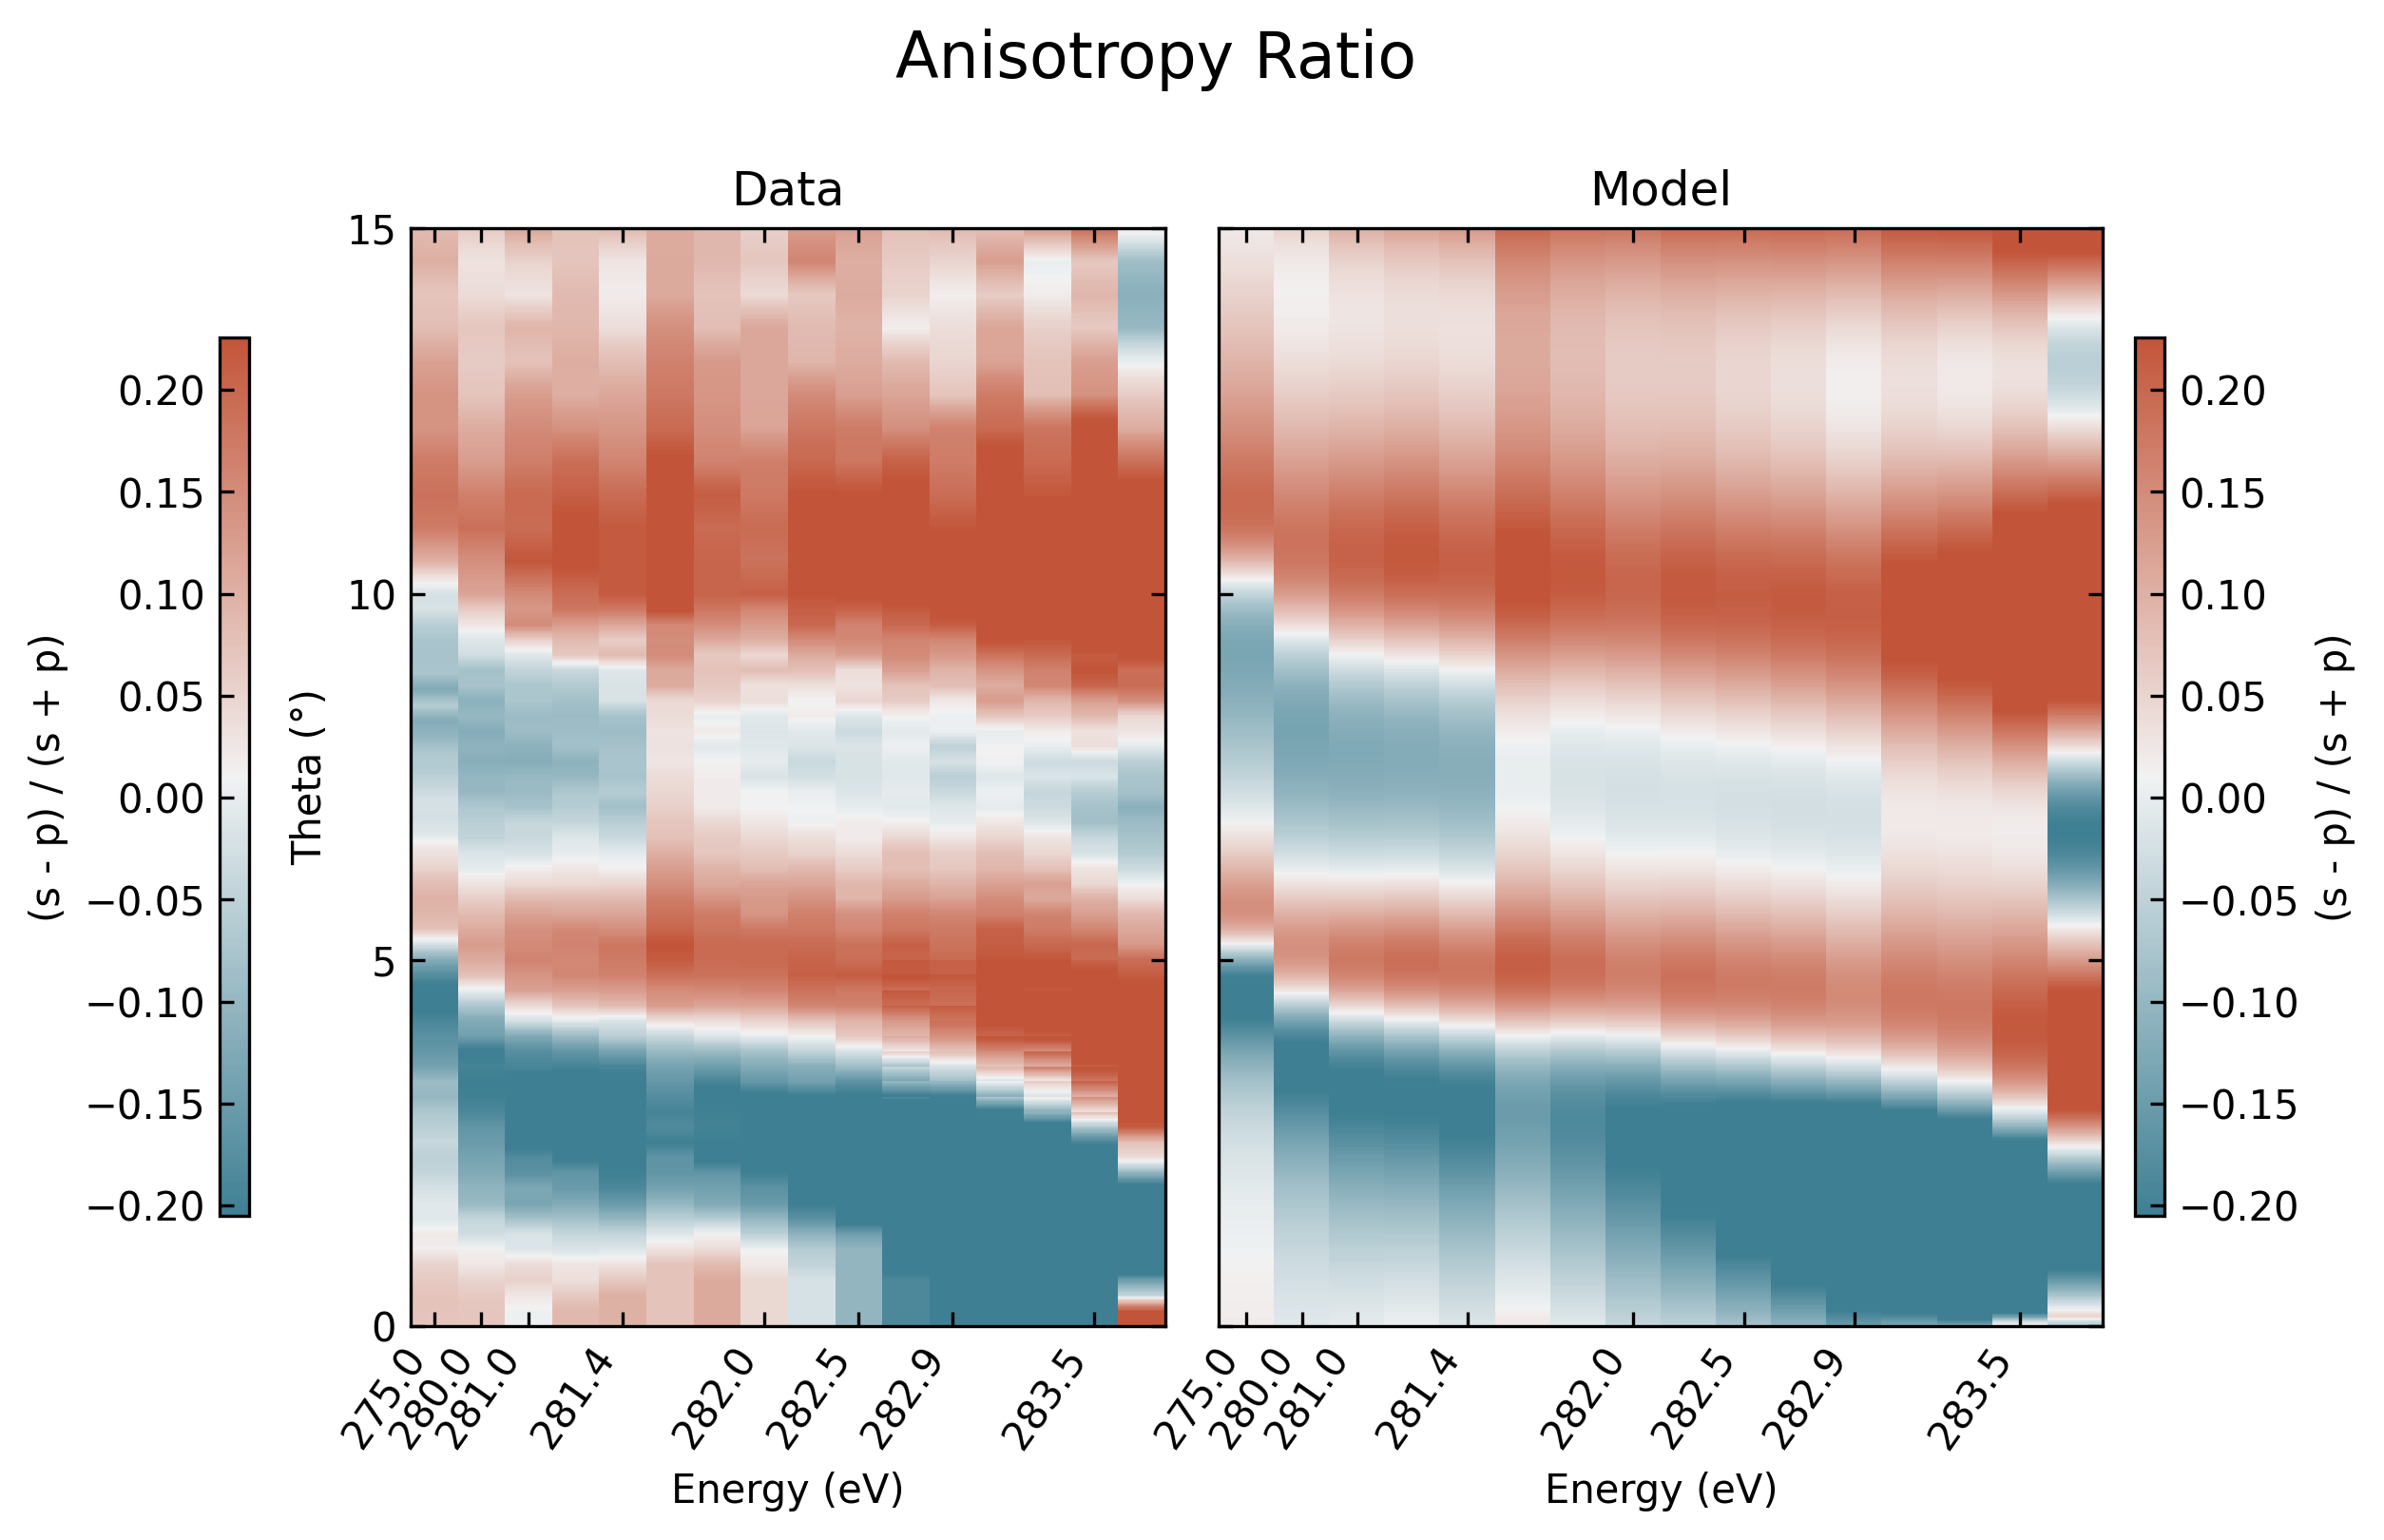

In [136]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
anisotropy_ratio = (s_reflectivity_map - p_reflectivity_map) / (
    s_reflectivity_map + p_reflectivity_map
)
anisotropy_ratio_model = (s_reflectivity_model - p_reflectivity_model) / (
    s_reflectivity_model + p_reflectivity_model
)
energies = np.array(energies)

# Find indices for the desired energy range
energy_indices = np.where((energies >= 275) & (energies <= 283.7))[0]
select_energies = energies[energy_indices]
selected_anisotropy_ratio = anisotropy_ratio[energy_indices, :]
selected_anisotropy_ratio_model = anisotropy_ratio_model[energy_indices, :]

# now plot the anisotropy ratio for both data and model
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), dpi=300, sharey=True, gridspec_kw={"wspace": 0.05}
)

vmin = np.quantile(selected_anisotropy_ratio, 0.1)
vmax = np.quantile(selected_anisotropy_ratio, 0.9)

# Plot experimental data anisotropy
im1 = ax1.imshow(
    selected_anisotropy_ratio.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(select_energies), common_theta.min(), common_theta.max()],
    cmap=cmap,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax1.set_title("Data")
ax1.set_ylabel("Theta (°)")
ax1.set_xlabel("Energy (eV)")

# Plot model anisotropy
im2 = ax2.imshow(
    selected_anisotropy_ratio_model.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(select_energies), common_theta.min(), common_theta.max()],
    cmap=cmap,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax2.set_title("Model")
ax2.set_xlabel("Energy (eV)")


# Generate ticks every 0.5 eV
tick_positions = []
tick_labels = []
# Round to nearest 0.5
start_energy = np.round(select_energies[0] * 2) / 2
end_energy = np.round(select_energies[-1] * 2) / 2

for energy_val in np.arange(start_energy, end_energy + 0.5, 0.5):
    # Find the index of the closest energy in the select_energies array
    closest_idx = np.argmin(np.abs(select_energies - energy_val))
    # Add the tick position and label if it's not already there
    if closest_idx + 0.5 not in tick_positions:
        tick_positions.append(closest_idx + 0.5)
        tick_labels.append(f"{select_energies[closest_idx]:.1f}")

# Set the ticks and labels for the x-axis for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=55, ha="right")
    ax.set_yticks([0, 5, 10, 15])
    ax.tick_params(axis="both")

# Add colorbars
cbar1 = fig.colorbar(
    im1,
    ax=ax1,
    label="(s - p) / (s + p)",
    location="left",
    pad=0.15,
    shrink=0.8,
    aspect=30,
)
cbar2 = fig.colorbar(
    im2,
    ax=ax2,
    label="(s - p) / (s + p)",
    location="right",
    pad=0.03,
    shrink=0.8,
    aspect=30,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Anisotropy Ratio", fontsize=16, y=1.02)
plt.show()


/tmp/ipykernel_166090/1644857325.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


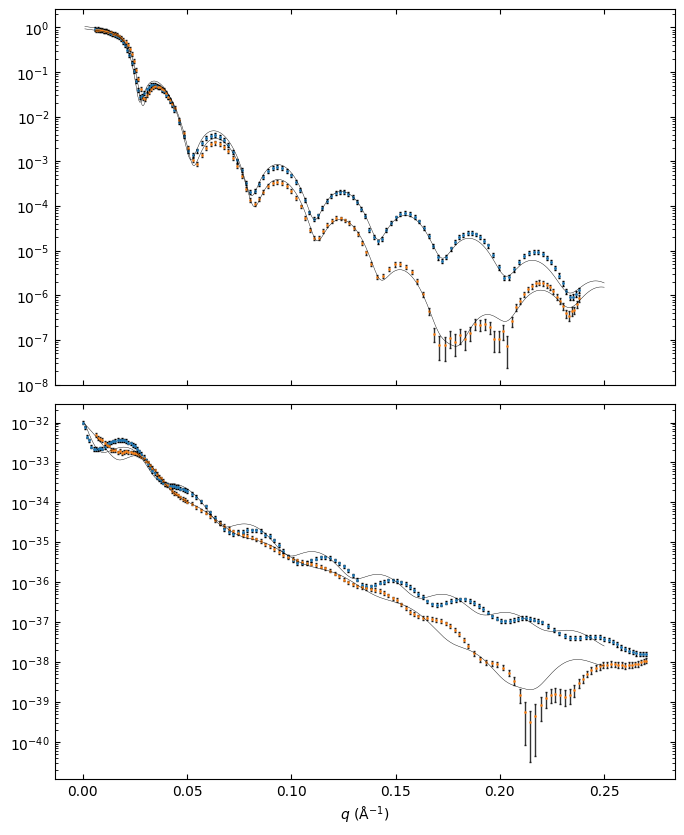

In [137]:
fig, axes = plt.subplots(
    2, 1, figsize=(8, 10), sharex=True, gridspec_kw={"hspace": 0.05}
)
energies_to_plot = [250.0, 283.7]

for i, objective in enumerate(fit_obj.objectives):
    model = objective.model
    e = model.energy
    if e not in energies_to_plot:
        continue  # Skip energies not in the list
    j = energies_to_plot.index(e)
    # print(model)
    d = objective.data

    # Calculate model reflectivity for s and p polarizations
    model_s = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)
    model_p = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)

    # Plot experimental data with an offset for clarity
    offset = 100**-i
    axes[j].errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="s-pol" if i == 1 else None,
        zorder=-1,
    )
    axes[j].errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="p-pol" if i == 1 else None,
        zorder=-1,
        alpha=0.8,
    )

    # Plot the fit lines
    axes[j].plot(
        q,
        model_s * offset,
        color="k",
        lw=0.3,
        zorder=2,
        label="fit" if i == 1 else None,
    )
    axes[j].plot(q, model_p * offset, color="k", lw=0.3, zorder=2)
for ax in axes:
    ax.set_yscale("log")
axes[-1].set_xlabel(r"$q\ (\mathrm{\AA}^{-1})$")
plt.tight_layout()
plt.show()

In [138]:
from refnx.reflect.interface import Erf, Step


def orientation_profile(slabs, z=None, step=False):
    """
    Series of depth profiles for the slab model used to calculated p-RSoXR.

    Parameters
    ----------
    slabs : Information regarding the layer stack, see PXR_Structure class
    z : float
        Interfacial distance (Angstrom) measured from interface between the
        fronting medium and the first layer.
    step : Boolean
        Set 'True' for slab model without interfacial widths


    Returns
    -------
    zed : float / np.ndarray
        Depth into the film / Angstrom

    index_tensor : complex / np.ndarray
        Real and imaginary tensor components of index of refraction / unitless
        Array elements: [nxx, nyy, nzz]

    Optional:

    index_step : complex / np.ndarray
        Real and imaginary tensor components of index of refraction / unitless
        Calculated WITHOUT interfacial roughness

    Notes
    -----
    This can be called in vectorised fashion.

    To calculate the isotropic components:
        index_iso = index_tensor.sum(axis=1)/3 #(nxx + nyy + nzz)/3
    To calculate the birefringence/dichroism:
        diff = index_tensor[:,0] - index_tensor[:,2] #nxx - nzz

    """
    nlayers = (
        np.size(slabs, 0) - 2
    )  # Calculate total number of layers (not including fronting/backing)

    # work on a copy of the input array
    layers = np.copy(slabs)
    layers[:, 0] = np.fabs(slabs[:, 0])  # Ensure the thickness is positive
    layers[:, 3] = np.fabs(slabs[:, 3])  # Ensure the roughness is positive
    # bounding layers should have zero thickness
    layers[0, 0] = layers[-1, 0] = 0

    # distance of each interface from the fronting interface
    dist = np.cumsum(layers[:-1, 0])
    total_film_thickness = int(
        np.round(dist[-1])
    )  # Total film thickness for point density
    # workout how much space the SLD profile should encompass
    # (if z array not provided)
    if z is None:
        zstart = -5 - 4 * np.fabs(slabs[1, 3])
        zend = 5 + dist[-1] + 4 * layers[-1, 3]
        zed = np.linspace(
            zstart, zend, num=total_film_thickness * 2
        )  # 0.5 Angstrom resolution default
    else:
        zed = np.asfarray(z)  # type: ignore[assignment]
    tensor_erf = (
        np.ones((len(zed), 3), dtype=float) * reduced_tensor[0]
    )  # Full wave of initial conditions
    tensor_step = np.copy(tensor_erf)  # Full wave without interfacial roughness
    delta_n = reduced_tensor[1:] - reduced_tensor[:-1]  # Change in n at each interface

    # use erf for roughness function, but step if the roughness is zero
    step_f = Step()  # Step function (see refnx documentation)
    erf_f = Erf()  # Error function (see refnx documentation)
    sigma = layers[1:, 3]  # Interfacial width parameter

    # accumulate the SLD of each step.
    for i in range(nlayers + 1):
        f = erf_f
        g = step_f
        if sigma[i] == 0:
            f = step_f
        tensor_erf += (
            delta_n[None, i, :] * f(zed, scale=sigma[i], loc=dist[i])[:, None]
        )  # Broadcast into a single item
        tensor_step += (
            delta_n[None, i, :] * g(zed, scale=0, loc=dist[i])[:, None]
        )  # Broadcast into a single item

    return zed, tensor_erf if step is False else tensor_step

In [139]:
fit_obj.objectives[0].model.structure.slabs()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.61238869e+01, 3.56938578e-03, 4.60835361e-04, 7.96774720e+00],
       [1.50613847e+02, 3.19422163e-03, 4.12571570e-04, 4.80564569e+01],
       [2.17473008e+01, 3.16064870e-03, 4.07651775e-04, 4.79441732e+00],
       [1.12898041e+01, 6.05618089e-03, 2.34143139e-03, 5.71480210e+00],
       [0.00000000e+00, 6.63761137e-03, 4.72432951e-03, 1.20000000e+00]])

In [ ]:
from refnx.reflect.interface import Erf, Step

sp = structure_params(fit_obj, "rotation")
orient = np.degrees(np.concatenate([[MA], [p.value for p in sp], [MA, MA]]))
errs = np.zeros_like(
    orient
)  # np.degrees(np.concatenate([[0], [p.stderr for p in sp], [0, 0]])) * 4
orient_lb = orient - errs
orient_ub = orient + errs
depth_profile_structure = fit_obj.objectives[0].model.structure

slabs = fit_obj.objectives[0].model.structure.slabs()
nlayers = (
    np.size(slabs, 0) - 2
)  # Calculate total number of layers (not including fronting/backing)

# work on a copy of the input array
layers = np.copy(slabs)
zstart = -5 * np.fabs(slabs[1, 3])
dist = np.cumsum(layers[:-1, 0])
zend = 5 + dist[-1] + 4 * layers[-1, 3]
offset = 3 * layers[-2, 3]
total_film_thickness = int(np.round(dist[-1])) + 10
zed = np.linspace(zstart - offset, zend + offset, total_film_thickness)
#  use the 4 * width of the second to last layer to set an offset

# dist -= offset

step_f = Step()  # Step function (see refnx documentation)
erf_f = Erf()  # Error function (see refnx documentation)
sigma = layers[1:, 3]  # Interfacial width parameter

rot_erf = np.degrees(MA)
rot_erf_lb = np.degrees(MA)
rot_erf_ub = np.degrees(MA)
rot_step = np.degrees(MA)
rot_step_lb = np.degrees(MA)
rot_step_ub = np.degrees(MA)
#  Get delta_r as the change in orientation at each interface from the list of orientations

diff_o = np.diff(orient)
diff_o_lb = np.diff(orient_lb)
diff_o_ub = np.diff(orient_ub)

# accumulate the SLD of each step.
for i in range(nlayers + 1):
    f = erf_f
    g = step_f
    if sigma[i] == 0:
        f = step_f
    rot_erf += diff_o[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_erf_lb += diff_o_lb[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_erf_ub += diff_o_ub[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_step += diff_o[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item
    rot_step_lb += diff_o_lb[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item
    rot_step_ub += diff_o_ub[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item


def find_interfaces(dist, zed, rot_erf):
    """
    Finds the interface locations for a given distance array.

    Parameters
    ----------
    dist : np.ndarray
        Array of interface distances.
    zed : np.ndarray
        Depth profile array.
    rot_erf : np.ndarray
        Orientation profile array.

    Returns
    -------
    interfaces : list
        A list of calculated interface locations.
    """
    if len(dist) < 3:
        print("Not enough interfaces to define a region.")
        return []

    # find the halfway point between dists
    midpoints = np.array([0.5 * (dist[i] + dist[i + 1]) for i in range(len(dist) - 1)])

    interfaces = []
    for i in range(len(midpoints) - 1):
        mask = (zed > midpoints[i]) & (zed < midpoints[i + 1])
        zed_region = zed[mask]
        rot_erf_region = rot_erf[mask]

        if len(zed_region) > 1:
            midpoint_orientation = 0.5 * (rot_erf_region[0] + rot_erf_region[-1])
            # find the zed value closest to these midpoint orientations
            interface = zed_region[
                np.abs(rot_erf_region - midpoint_orientation).argmin()
            ]
            interfaces.append(interface)
        else:
            print(f"Could not find interface in region {i + 1}")

    return interfaces


# Example usage with the existing variables
interfaces = find_interfaces(dist, zed, rot_erf)

In [142]:
print(interfaces)

[np.float64(40.91765350307755), np.float64(176.36943945370828), np.float64(196.48604132756432)]


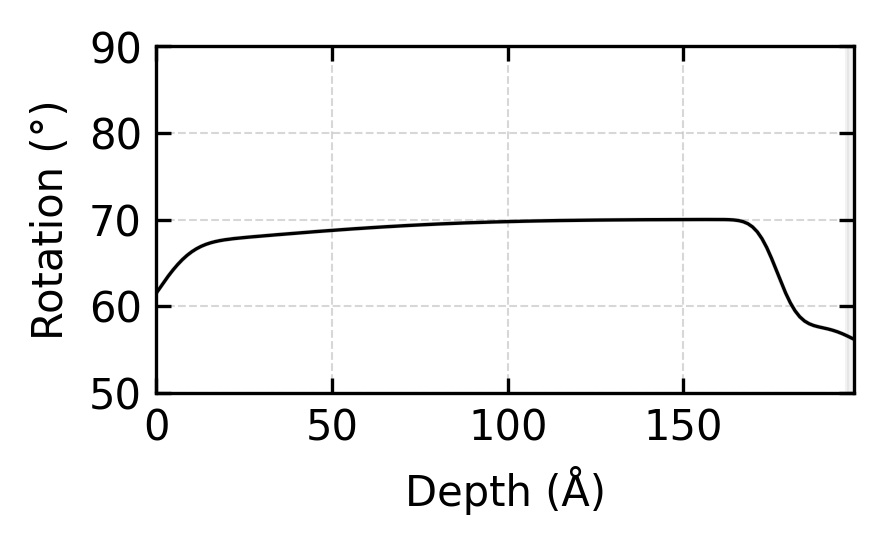

In [143]:
#  plot the rot_erf vs zed
import matplotlib.pyplot as plt


def plot_rotation_profile(ax, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA):
    """
    Plots the rotation profile with error bands and layer spans.
    """
    # ax.axhline(np.degrees(MA), color="k", lw=0.8)
    ax.plot(zed, rot_erf, linestyle="-", color="k", lw=0.8)
    ax.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.1)
    ax.set_xlabel("Depth (Å)")
    ax.set_ylabel("Rotation (°)")
    ax.set_yticks([50, 60, 70, 80, 90])
    ax.set_xlim(0, dist[-2])
    #  format the ticks to include the magic angle as a label
    ax.set_yticklabels(["50", "60", "70", "80", "90"])
    ax.grid(True, linestyle="--", alpha=0.5)

    #  Define the interface boundaries from the half way orientation between subsequent
    #  slabs
    interfaces = find_interfaces(dist, zed, rot_erf)
    ax.axvline(0, color="grey", lw=0.5, ls="-")
    # for i, _ in enumerate(interfaces):
    #     ls = interfaces[i - 1] if i > 0 else 0
    #     rs = interfaces[i] if i < len(interfaces) else zed.max()
    #     ax.axvspan(ls, rs, color=f"C{i}", alpha=0.1, label=f"Layer {i + 1}")
    ax.axvspan(
        interfaces[-1],
        zed.max(),
        color="grey",
        alpha=0.1,
    )
    # ax.legend(
    #     loc="center",
    #     fontsize="small",
    #     handlelength=0.5,
    # )
    return ax


fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)
plot_rotation_profile(ax, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA)
plt.show()

In [144]:
#  set matplotlib ticks to point inward
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["text.usetex"] = True
# Add ticks to the top and right side of every axis
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
# Set the grids so that they are dashed
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
# Ensure grids draw on minor ticks
plt.rcParams["axes.grid.which"] = "both"


/tmp/ipykernel_166090/1522268610.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


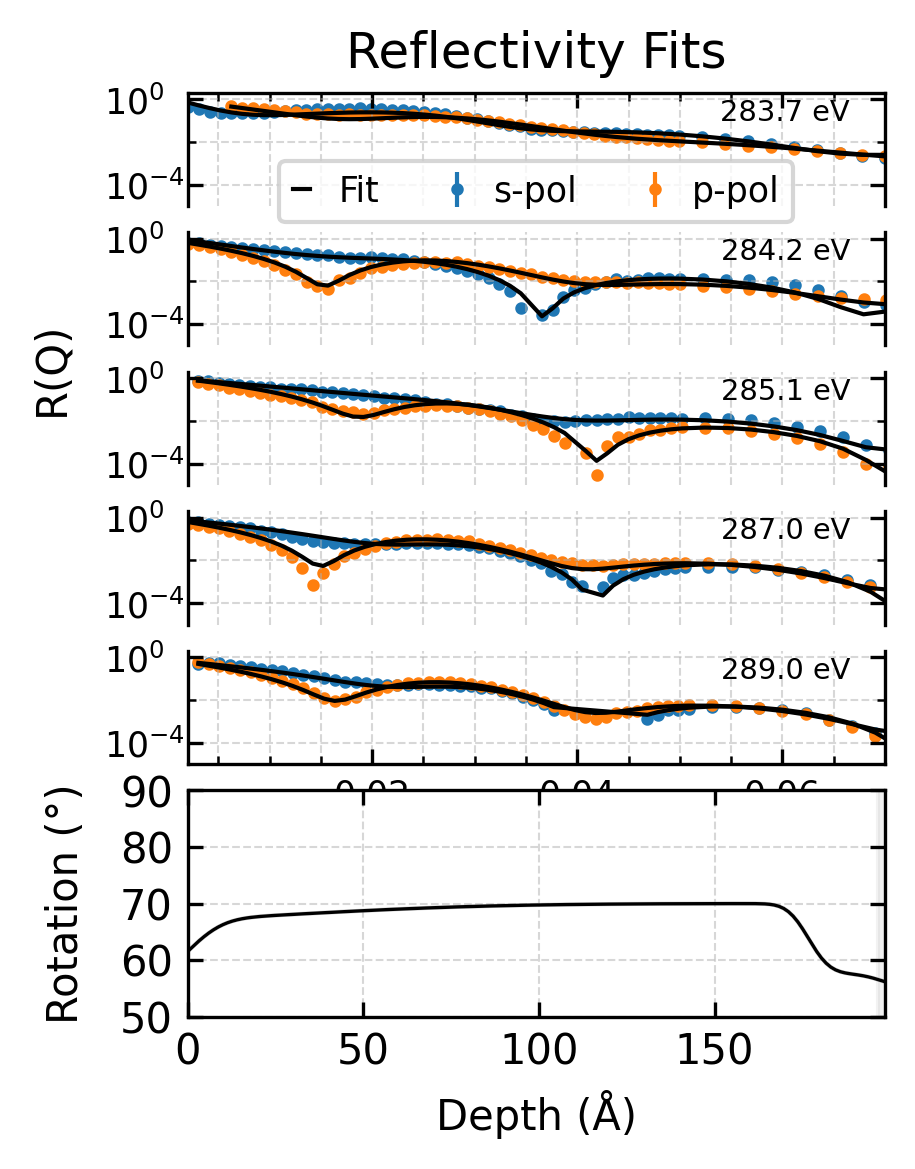

In [145]:
from matplotlib.ticker import NullFormatter

# Create a figure with six subplots arranged vertically
# The top 5 are for reflectivity, the bottom one for the depth profile
fig, axes = plt.subplots(
    6,
    1,
    figsize=(3, 4),  # Adjusted figsize for better visibility
    dpi=300,
    gridspec_kw={"hspace": 0.2, "height_ratios": [1, 1, 1, 1, 1, 2]},
)


# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = energies[-5:]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    # For the first subplot, it shares with no one yet.
    # For subsequent subplots (i > 0), share the x-axis with the first subplot (axes[0]).
    ax = axes[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit")
    ax.plot(d.p.x, model_p, color="k", lw=1)

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i > 0:
        ax.sharex(axes[0])
    if i < 4:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.3),
        )
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    elif i < 4:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
    # Set major ticks
    ax.set_yticks([1e-4, 1])
    # Set minor ticks
    ax.set_yticks([1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-5, top=2)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes[0].set_title("Reflectivity Fits")
axes[4].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = axes[5]
plot_rotation_profile(ax_bottom, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA)

fig.tight_layout()
fig.align_labels()
plt.show()


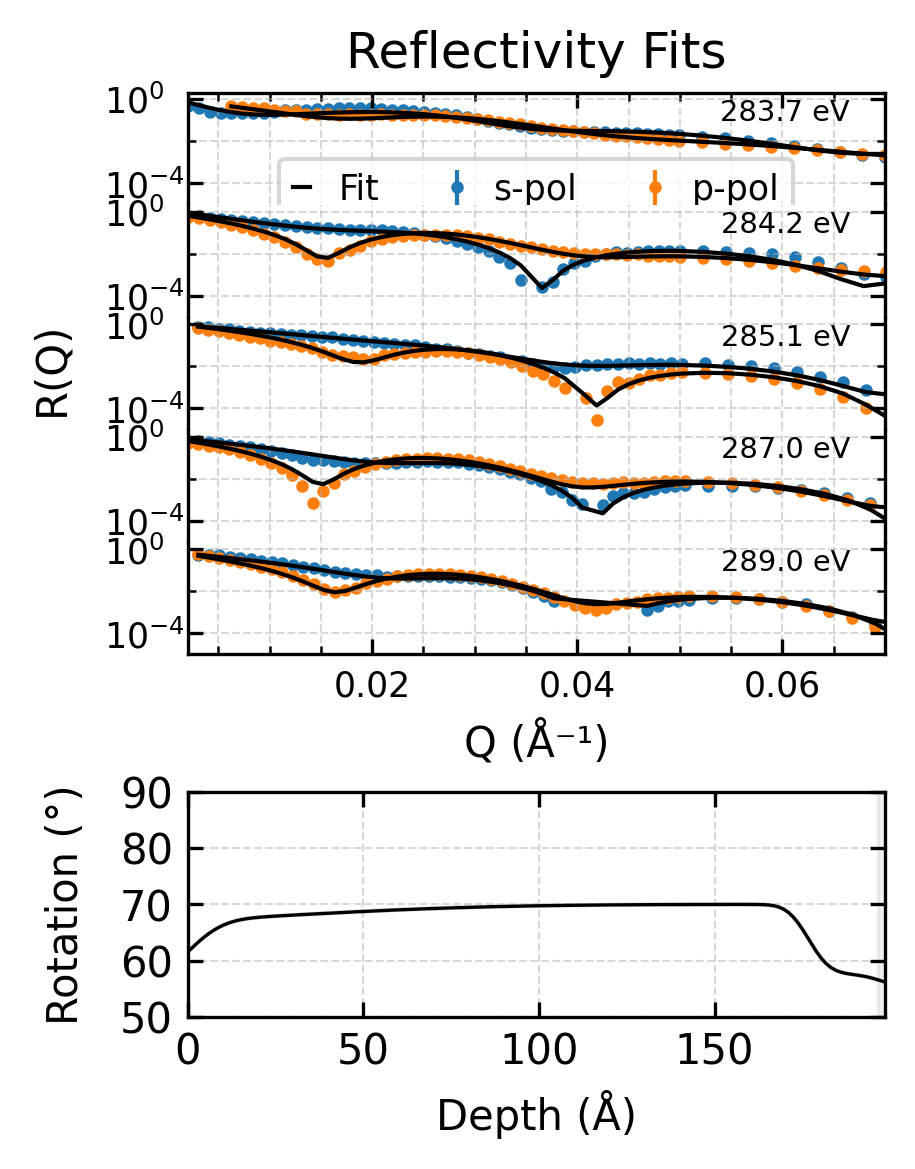

In [146]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plots will be larger
# hspace controls the space between the two main sections
gs_main = gridspec.GridSpec(2, 1, height_ratios=[5, 2], hspace=0.35, figure=fig)

# Create a nested GridSpec for the 5 reflectivity plots in the top part
# hspace=0 here makes them stick together vertically
gs_refl = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[0], hspace=0.01)

axes_refl = []
axes_refl.append(fig.add_subplot(gs_refl[0]))
for i in range(1, 5):
    axes_refl.append(fig.add_subplot(gs_refl[i], sharex=axes_refl[0]))

energies = [obj.model.energy for obj in fit_obj.objectives]

# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = energies[-5:]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    ax = axes_refl[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit")
    ax.plot(d.p.x, model_p, color="k", lw=1)

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i < 4:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.3),
        )
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    elif i < 4:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
    # Set major ticks
    ax.set_yticks([1e-4, 1])
    # Set minor ticks
    ax.set_yticks([1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-5, top=2)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes_refl[0].set_title("Reflectivity Fits")
axes_refl[4].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
plot_rotation_profile(ax_bottom, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA)

fig.align_labels()
plt.show()

/tmp/ipykernel_166090/1964971023.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


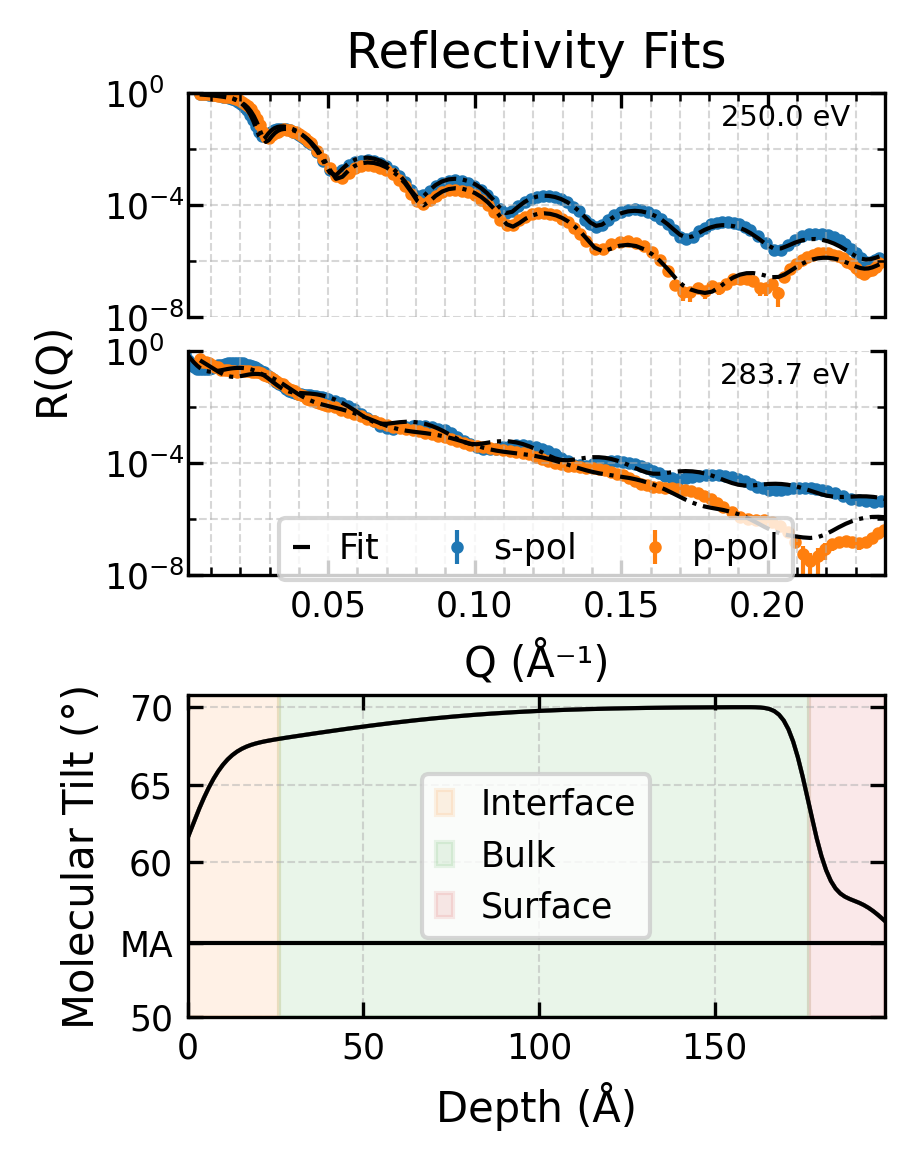

In [147]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plots will be larger
# Increased hspace to prevent label overlap
gs_main = gridspec.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.3, figure=fig)

# Create a nested GridSpec for the 5 reflectivity plots in the top part
# hspace=0 here makes them stick together vertically
gs_refl = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_main[0], hspace=0.15)

axes_refl = []
axes_refl.append(fig.add_subplot(gs_refl[0]))
axes_refl.append(fig.add_subplot(gs_refl[1], sharex=axes_refl[0]))


# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = [250, 283.7]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    ax = axes_refl[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit", ls="-.")
    ax.plot(d.p.x, model_p, color="k", lw=1, ls="-.")

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.24)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i < 1:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    # elif i < 4:
    #     ax.tick_params(
    #         axis="x", which="both", bottom=False, top=False, labelbottom=False
    #     )
    #     ax.spines["top"].set_visible(False)
    #     ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.1),  # Move legend slightly lower to avoid overlap
        )
    # Set major ticks
    ax.set_yticks([1e-8, 1e-4, 1])
    ax.set_yticks([1e-6, 1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-8, top=1)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes_refl[0].set_title("Reflectivity Fits")
axes_refl[1].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
ax_bottom.axhline(np.degrees(MA), color="k", lw=1)
ax_bottom.plot(zed, rot_erf, linestyle="-", color="k", lw=1)
ax_bottom.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.3)
ax_bottom.set_xlabel("Depth (Å)")
ax_bottom.set_ylabel("Molecular Tilt (°)")
ax_bottom.set_yticks([50, np.degrees(MA), 60, 65, 70])
ax_bottom.set_xlim(0, dist[-2])
#  format the ticks to include the magic angle as a label
ax_bottom.set_yticklabels(["50", "MA", "60", "65", "70"])
ax_bottom.grid(True, linestyle="--", alpha=0.5)
ax_bottom.tick_params(axis="both", labelsize="small")

for i, slab in enumerate(slabs):
    if i == 0:
        ax_bottom.axvspan(dist[0], dist[1], color="C1", alpha=0.1, label="Interface")
    elif i == 1:
        ax_bottom.axvspan(
            dist[1],
            dist[2],
            color="C2",
            alpha=0.1,
            label="Bulk",
        )
    elif i == 2:
        ax_bottom.axvspan(
            dist[2],
            dist[3],
            color="C3",
            alpha=0.1,
            label="Surface",
        )
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)

# Use tight_layout instead of align_labels for better spacing
plt.tight_layout()
plt.show()

/tmp/ipykernel_166090/3263814148.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


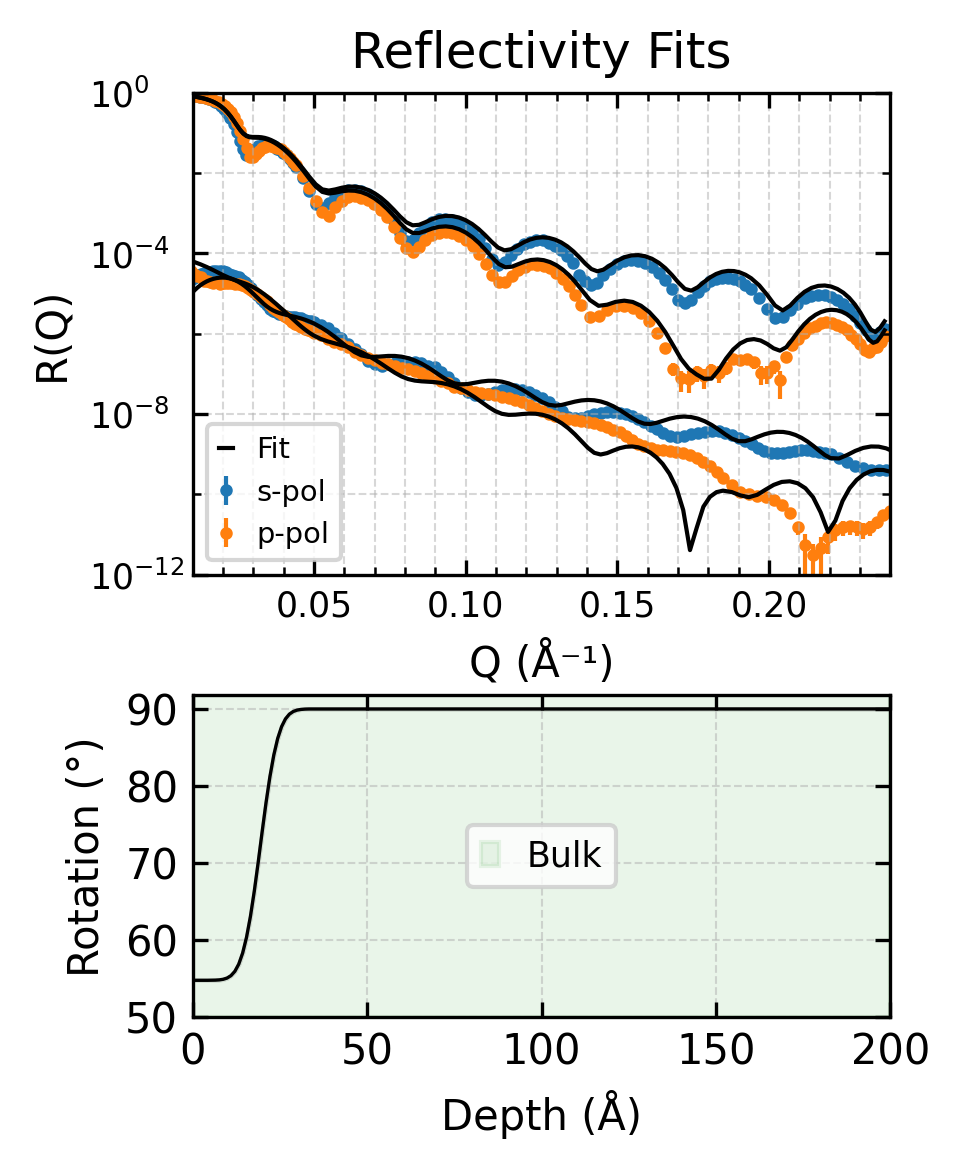

In [106]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plot, bottom for depth profile
gs_main = gridspec.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.3, figure=fig)

# Create a single axes for the combined reflectivity plot
ax_refl = fig.add_subplot(gs_main[0])

# --- Combined Reflectivity Plot ---
# Get the two energies to plot
target_energy = [250, 283.7]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

offset_factor = 1e-4  # Offset for the second plot

for i, obj in enumerate(objective_to_plot):
    model = obj.model
    d = obj.data

    # Apply offset to the second plot (i=1)
    offset = offset_factor if i == 1 else 1.0

    # Plot experimental data
    ax_refl.errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol" if i == 0 else None,
        zorder=-1,
    )
    ax_refl.errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol" if i == 0 else None,
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines with offset
    ax_refl.plot(
        d.s.x,
        model_s * offset,
        color="k",
        lw=1,
        ls="-",
        label="Fit" if i == 0 else None,
    )
    ax_refl.plot(d.p.x, model_p * offset, color="k", lw=1, ls="-")

ax_refl.set_yscale("log")
ax_refl.set_xlim(0.01, 0.24)
ax_refl.minorticks_on()
ax_refl.grid(True, which="both", linestyle="--", alpha=0.5)

# Set major ticks
ax_refl.set_yticks([1e-12, 1e-8, 1e-4, 1])
ax_refl.set_yticks([1e-10, 1e-6, 1e-2], minor=True)
ax_refl.yaxis.set_minor_formatter(NullFormatter())
ax_refl.set_ylim(bottom=1e-12, top=1)

# set the tick label font
ax_refl.tick_params(axis="y", which="major", pad=25)
ax_refl.tick_params(axis="both", labelsize="small")
for label in ax_refl.get_yticklabels():
    label.set_horizontalalignment("left")

# Add legend
ax_refl.legend(
    fontsize="x-small",
    loc="lower left",
    handlelength=0.5,
)

# Add y-label
ax_refl.set_ylabel("R(Q)", rotation="vertical")
ax_refl.set_title("Reflectivity Fits")
ax_refl.set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
plot_rotation_profile(
    ax_bottom, zed[::-1], rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA
)
ax_bottom.axvspan(dist[0], dist[1], color="C2", alpha=0.1, label="Bulk")
# Use tight_layout instead of align_labels for better spacing
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)
plt.tight_layout()
plt.show()